In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, TransformerConv, global_mean_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, auc

In [2]:
# Read from csv (without second list in daughter columns - see data_loading.ipynb)
train_df = pd.read_csv('new_train_data.csv')
test_df = pd.read_csv('new_test_data.csv')

In [184]:
# Track/ daughter kinematic features
train_d_cols = list(train_df[train_df.columns[train_df.columns.str.contains("_Daughters")]])
test_d_cols = list(test_df[test_df.columns[test_df.columns.str.contains("_Daughters")]])

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT']
test_jet_cols = ['Jet1_Eta', 'Jet1_PT']

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

In [4]:
# Duplicate Jet PT and Eta elements as a list the same length as the number of daughters in each row
def duplicate(df, cols, n_col):
    def duplicate_value(row, col, n_col):
        value = row[col]
        if isinstance(value, (float, int)):
            num_daughters = row[n_col]
            return [value] * num_daughters
        return value

    for col in cols:
        df[col] = df.apply(lambda row: duplicate_value(row, col, n_col), axis=1)
    return df

# Converts string into list of floats (already duplicated and dropped second array)
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

In [5]:
# Duplicate and preprocess daughter columns
train_df = duplicate(train_df, ['Jet0_PT', 'Jet0_Eta', 'IsB'], 'Jet0_nDaughters')
test_df = duplicate(test_df, ['Jet1_PT', 'Jet1_Eta', 'IsB'], 'Jet1_nDaughters')

# Clean up data from str to list of floats
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

In [6]:
# Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [7]:
# Select first 500 sig aand first 500 bgk data for quicker training
cut_train_df = pd.concat([train_df.head(1000), train_df.iloc[100000:101000]]) 
cut_test_df = pd.concat([test_df.head(1000), test_df.iloc[100000:101000]])

In [560]:
# New - returns features as array of [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    for _, row in df.iterrows():
        # Determine the number of nodes (maximum length of daughter features)
        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        
        # Initialize a list of lists for this jet's nodes
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]
            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                # Scalar value, add to all nodes
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

In [735]:
train_features = node_features(cut_train_df, train_f_cols)
test_features = node_features(cut_test_df, test_f_cols)

In [736]:
def create_data_objects(features_array, labels):
    data_objects = []
    
    for jet_idx, jet_features in enumerate(features_array):
        x = torch.tensor(jet_features, dtype=torch.float)
        
        # Number of nodes for this jet
        num_nodes = x.size(0) 
        
        # Create fully connected edges
        edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        
        y = torch.tensor(labels[jet_idx], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        
        data_objects.append(data)
    
    return data_objects

# Create Data objects
train_labels = cut_train_df['IsB'].tolist()
train_data = create_data_objects(train_features, train_labels)

test_labels = cut_test_df['IsB'].tolist()
test_data = create_data_objects(test_features, test_labels)

In [795]:
# Load data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Training Model

In [914]:
# Define GNN model

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 128
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.sigmoid(x)
        x = self.lin(x)
        return x.squeeze(1)
            
model = GNN()

In [915]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
    return loss.item()

def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data)
            pred = (torch.sigmoid(out) > 0.5).float()
            correct = (pred.squeeze() == data.y).sum().item()
            total_correct += correct
            total_samples += len(data.y)

    accuracy = total_correct / total_samples
    return accuracy

for epoch in range(10):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    #scheduler.step(train_loss)

Epoch: 001, Loss: 0.6919, Train Acc: 0.5116, Test Acc: 0.5177
Epoch: 002, Loss: 0.6800, Train Acc: 0.5457, Test Acc: 0.5463
Epoch: 003, Loss: 0.6705, Train Acc: 0.5199, Test Acc: 0.5236
Epoch: 004, Loss: 0.6993, Train Acc: 0.5199, Test Acc: 0.5236
Epoch: 005, Loss: 0.7082, Train Acc: 0.5199, Test Acc: 0.5236
Epoch: 006, Loss: 0.6987, Train Acc: 0.5184, Test Acc: 0.5222
Epoch: 007, Loss: 0.6600, Train Acc: 0.5199, Test Acc: 0.5236
Epoch: 008, Loss: 0.7046, Train Acc: 0.5199, Test Acc: 0.5236
Epoch: 009, Loss: 0.6940, Train Acc: 0.5199, Test Acc: 0.5236
Epoch: 010, Loss: 0.6993, Train Acc: 0.5199, Test Acc: 0.5236


In [916]:
# Check gradients to see if they are exploding or vanishing
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.view(-1), data.y.float())
    loss.backward()
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: grad_norm: {param.grad.norm().item()}")

check_gradients()

conv1.lin_rel.weight: grad_norm: 0.0
conv1.lin_rel.bias: grad_norm: 0.0
conv1.lin_root.weight: grad_norm: 0.0
conv2.lin_rel.weight: grad_norm: 0.0
conv2.lin_rel.bias: grad_norm: 0.0
conv2.lin_root.weight: grad_norm: 0.0
conv3.lin_rel.weight: grad_norm: 0.0
conv3.lin_rel.bias: grad_norm: 0.0
conv3.lin_root.weight: grad_norm: 0.0
conv4.lin_rel.weight: grad_norm: 0.0
conv4.lin_rel.bias: grad_norm: 0.0
conv4.lin_root.weight: grad_norm: 0.0
lin.weight: grad_norm: 0.6252915859222412
lin.bias: grad_norm: 0.08282113075256348


# ROC Curve and AUC

In [816]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [817]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

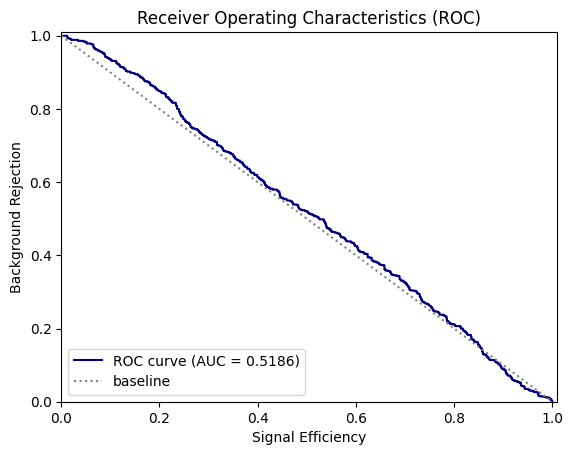

In [818]:
# Plot ROC Curve and show AUC
plt.plot(sig_eff, back_rej, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.show()

Old Method for creating data object - incorrectly adds features

In [533]:
# Creates list of node features (float) - features[x][y], x = row index, y = index of feature column
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

# Creates a data object of each df
def create_data_object(df, features_cols):
    
    df = df.sample(frac=1).reset_index(drop=True) # shuffles data before creating data object
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        
    return data_list

In [534]:
trdata = create_data_object(cut_train_df, train_f_cols)